# fig5_ivt
SALLJ composites of integrated vapor transport (IVT)


## Imports

In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units


In [2]:
# Set up paths
home = Path.home()                 # users home directory
root = home/'repos'/'montini-phd'    # project root directory
path_to_data = root/'data'           # data directory (input data, read only)
path_to_out = root/'out'             # directory for storing numerical results and intermediate datafiles (read & write
path_to_figs = root/'figs'           # directory for storing figures


In [3]:
# Path to modules directory
path_to_mods = os.fspath(root/'modules')
sys.path.append(path_to_mods)

# Import my modules
from plotter import draw_basemap


In [4]:
# Set a default font for all matplotlib text (after setting, must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Data

### SALLJ days

In [5]:
filepath = path_to_out / 'sallj-types-ndjfm.csv'
df = pd.read_csv(filepath)


              DATE  LLJ_CAT
0     11/1/79 9:00        0
1     11/2/79 9:00        0
2     11/3/79 9:00        0
3     11/4/79 9:00        0
4     11/5/79 9:00        0
...            ...      ...
5592  3/27/16 9:00        0
5593  3/28/16 9:00        0
5594  3/29/16 9:00        0
5595  3/30/16 9:00        0
5596  3/31/16 9:00        0

[5597 rows x 2 columns]


### ERA5 renalysis

In [6]:
# Reanalysis data (read data into xarray datasets)
f1 = xr.open_dataset(path_to_data/'era5_ivte_sfc_day_1979-2016_sam.nc')
f2 = xr.open_dataset(path_to_data/'era5_ivtn_sfc_day_1979-2016_sam.nc')

# merge variables into single dataset
era = xr.merge([f1,f2])

# Trim date range
start_date = '1979-11-01'
end_date = '2016-03-31'
idx = slice(start_date, end_date)
era = era.sel(time=idx)

# Select NDJFM months
idx = (era.time.dt.month >= 11) | (era.time.dt.month <= 3)
era = era.sel(time=idx)


In [7]:
# Combine SALLJ data w/ reanalysis data

# Add llj time series to the ERA dataset
era['llj'] = ('time', df.LLJ_CAT)
era = era.set_coords('llj')

# Select only LLJ days
idx = (era.llj >= 1)
era_llj = era.sel(time=idx)

# print results
print(era_llj)

<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 131, longitude: 111, time: 1765)
Coordinates:
  * longitude  (longitude) float32 -85.0 -84.5 -84.0 -83.5 ... -31.0 -30.5 -30.0
  * latitude   (latitude) float32 15.0 14.5 14.0 13.5 ... -49.0 -49.5 -50.0
  * time       (time) datetime64[ns] 1979-11-07T09:00:00 ... 2016-03-18T09:00:00
    llj        (time) int64 4 2 2 4 2 1 1 3 4 2 1 2 ... 3 3 4 4 3 1 3 2 2 2 3 3
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1979-11-07 ... 2016-03-18T18:00:00
    ivte       (time, latitude, longitude) float64 ...
    ivtn       (time, latitude, longitude) float64 ...


### Compute SALLJ composites

In [8]:
# Compute composites of each SALLJ type
era_llj_comp = era_llj.groupby('llj').mean('time')
print(era_llj_comp)

<xarray.Dataset>
Dimensions:    (latitude: 131, llj: 4, longitude: 111)
Coordinates:
  * longitude  (longitude) float32 -85.0 -84.5 -84.0 -83.5 ... -31.0 -30.5 -30.0
  * latitude   (latitude) float32 15.0 14.5 14.0 13.5 ... -49.0 -49.5 -50.0
  * llj        (llj) int64 1 2 3 4
Data variables:
    ivte       (llj, latitude, longitude) float64 -130.7 -148.3 ... 256.1 255.3
    ivtn       (llj, latitude, longitude) float64 -92.38 -105.2 ... -48.74 -44.9


## Figure 5

### Data for plotting

In [9]:
# lat/lon arrays
lats = era_llj_comp.latitude.values
lons = era_llj_comp.longitude.values

# IVT
uvec = era_llj_comp.ivte.values
vvec = era_llj_comp.ivtn.values
ivt = np.sqrt(uvec**2 + vvec**2)


### Common plot properties

In [10]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set map extent
lonmin = -85.0
lonmax = -30.0
latmin = -50.0
latmax = 15.0

# Set tickmark locations
dx = np.arange(-80,lonmax,20)
dy = np.arange(-40,latmax,20)

# Labels
plt_labels = ['SALLJ Type 1', 'SALLJ Type 2', 'SALLJ Type 3','SALLJ Type 4']


### Create figure

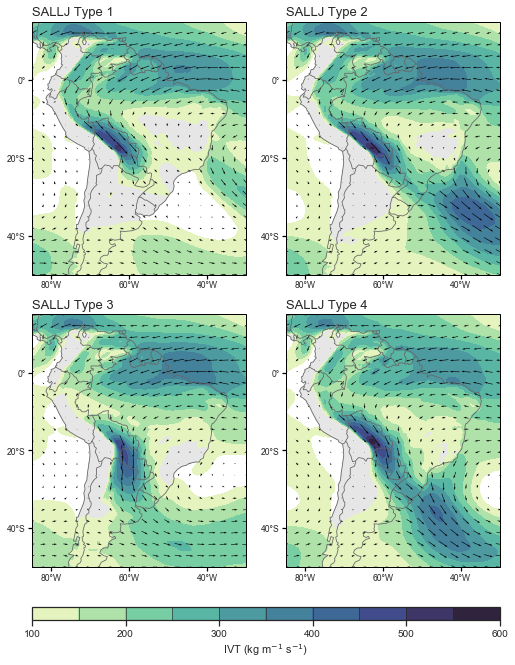

In [12]:
 # Create figure
fig = plt.figure(figsize=(10,11))
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.0, cbar_size='2.5%',label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # IVT (filled contour)
    clevs_ivt = np.arange(100,601,50)
    cf = ax.contourf(lons, lats, ivt[k,:,:], transform=datacrs,
                    levels=clevs_ivt, cmap=cmo.deep)
    
    # IVT vectors
    ax.quiver(lons, lats, uvec[k,:,:], vvec[k,:,:], transform=datacrs,
        color='black', regrid_shape=20, pivot='middle')
    
    # Subtitles
    ax.set_title(plt_labels[k], loc='left', fontsize=13)
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=10)
      
# Save figure
filepath = path_to_figs / 'fig5.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
    